In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
from numpy import linalg as LA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.utils import shuffle

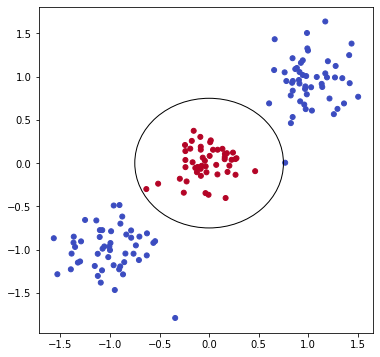

In [35]:
def gaussian_basis(x, y, cx, cy):
    return np.exp(-((x-cx)**2 + (y-cy)**2) * gamma)

def graph(f):
    X, Y = np.meshgrid(np.linspace(-1.5, 1.5, 100), np.linspace(-1.5, 1.5, 100))
    Z = np.vectorize(f)(X,Y)
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.pcolor(X, Y, Z, alpha=0.3)
    plt.colorbar()
    plt.scatter(train_x, train_y, c = train_t, s = 25, cmap=cm.coolwarm)
    plt.title("iter=" + str(count))
    plt.show()

N = 50
mu1 = [0, 0]
mu2 = [-1, -1]
mu3 = [1, 1]
sigma1 = sigma2 = sigma3 = np.eye(2) * 0.05
 
data1 = np.random.multivariate_normal(mu1, sigma1, N)
data2 = np.random.multivariate_normal(mu2, sigma2, N)
data3 = np.random.multivariate_normal(mu3, sigma3, N)
data = np.concatenate((data1, data2, data3), axis = 0)
 
train_x = data[:, 0]
train_y = data[:, 1]
train_t = train_x**2+train_y**2 < 0.75 ** 2    #教師データ
 
plt.figure(figsize=(6, 6))
plt.scatter(data[:,0], data[:,1], c = train_t, s = 25, cmap=cm.coolwarm)
#円をかく
circle = plt.Circle((0, 0), 0.75, fill=False)
plt.gcf().gca().add_artist(circle)
plt.show()

In [17]:
def phi(x, y):
    return np.array([gaussian_basis(x, y, cx, cy) for cx,cy in basis_center])
def sigmoid(x):
  return 1/(1 + np.exp(-x))

ベイズロジスティクス回帰

In [40]:
N = 150
alpha = 10
e = 0.1
gamma = 1
basis_num = 5
dims = basis_num ** 2

basis_center = [(x, y) for x in np.linspace(-1.5, 1.5, basis_num)
                       for y in np.linspace(-1.5, 1.5, basis_num)]
# 初期値

w = np.zeros(dims) #(dims,)
Phi = phi(train_x, train_y) #(dims, N)
print(Phi.shape)

S_0 = np.eye(dims) / alpha #(dims,dims)
S_0_inv = alpha * np.eye(dims) #(dims, dims)
m_0 = 0

#Newton法で最大事後分布パラメータを決める
for i in range(10):
  y = sigmoid(w@Phi) #(N)
  R = np.diag(y * (1-y)) #(N,N)
  S_n_inv = S_0_inv + Phi@R@Phi.T #(dim,dim)
  S_n = LA.inv(S_n_inv)

  w = w - np.linalg.solve( S_n_inv, Phi@(y - train_t) + S_0_inv @ (w - m_0) )
  print(LA.norm(w))


(25, 150)
1.8492556073311686
1.9878743527266436
1.9900189107377044
1.990019690949969
1.9900196909500931
1.990019690950093
1.9900196909500931
1.9900196909500931
1.990019690950093
1.990019690950093


In [37]:
def graph(f):
    X, Y = np.meshgrid(np.linspace(-1.5, 1.5, 100), np.linspace(-1.5, 1.5, 100))
    Z = np.vectorize(f)(X,Y)
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.pcolor(X, Y, Z, alpha=0.3)
    plt.colorbar()
    plt.scatter(train_x, train_y, c = train_t, s = 25, cmap=cm.coolwarm)
    plt.title("iter=" + str(count))
    plt.show()

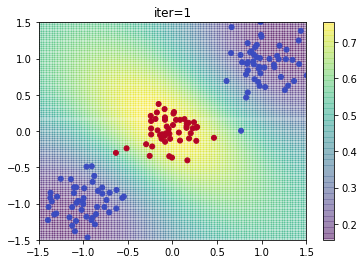

In [42]:
def mu_a(x, y):
  return w.dot(phi(x,y))

def sigma_a(x,y):
  return phi(x,y)@S_n@phi(x,y)

def kai(x):
  return np.sqrt(1 + np.pi * x / 8)

def p_C1(x,y):
  return sigmoid(mu_a(x,y) * kai(sigma_a(x,y)))
count = 1
graph(p_C1)

多クラスロジスティクス回帰

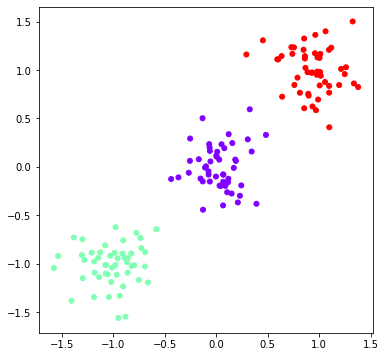

In [45]:
y = np.array([0,2,1,3,4,1])
def one_hot_encoder(arr, num_class):
  return np.eye(num_class)[arr]

N = 50
mu1 = [0,0]
mu2 = [-1,-1]
mu3 = [1,1]
sigma1 = sigma2 = sigma3 = np.eye(2) * 0.05
data1 = np.random.multivariate_normal(mu1, sigma1, N)   #クラス1
data2 = np.random.multivariate_normal(mu2, sigma2, N)   #クラス2
data3 = np.random.multivariate_normal(mu3, sigma3, N)
data = np.concatenate((data1, data2, data3), axis=0) #(3N,2)
train_x = data[:,0]
train_y = data[:,1]
train_t = np.concatenate((np.repeat(0, 50), np.repeat(1,50), np.repeat(2,50)), axis=0)

plt.figure(figsize=(6,6))
plt.scatter(data[:,0], data[:,1], c=train_t, s=25, cmap=cm.rainbow)
plt.show()

In [49]:
K = 3
T = one_hot_encoder(train_t, K)

W = np.zeros([dims, K]) #(dim,K)
count = 0

Phi = phi(train_x, train_y).T #(N, dims)
print(Phi.shape)

(150, 25)


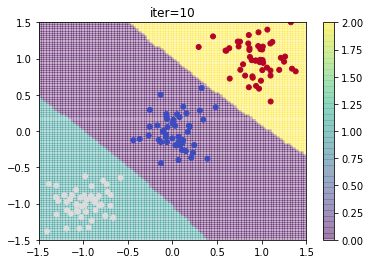

In [50]:
# 最急降下法
for i in range(10):
  Y_ = np.exp(Phi@W) #(N,K)
  Y = Y_ / Y_.sum(axis=1)[:, np.newaxis]
  W = W - Phi.T.dot(Y-T)
  count += 1

N = 100
f = lambda x,y: np.argmax(W.T@(phi(x,y)))

graph(f)

IRLS

(150, 25)


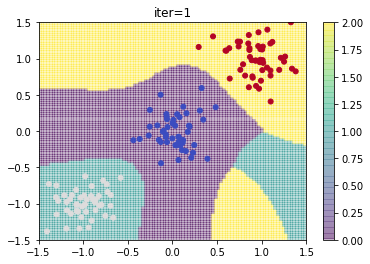

In [53]:
#K = クラス数
K = 3
T = one_hot_encoder(train_t, K)
 
N = 150 #サンプル数
 
R =np.zeros([K, N, N])   #三次元テンソル
 
#Wの初期値
W = np.zeros([dims, K])
count = 0
 
 
#計画行列
Phi = phi(train_x, train_y).T
print(Phi.shape)   #特徴数 * サンプル数
 
#初期値Y
Y_ = np.exp(Phi.dot(W))
Y = Y_ / Y_.sum(axis=1)[:, np.newaxis]
 
#IRLS   ==== ここだけ変える  ====

for i in range(1):
  Y_ = np.exp(Phi@W)
  Y = Y_ / Y_.sum(axis=1)[:, np.newaxis]
  for k in range(K):
    R[k, :, :] = np.diag(Y[:,k] * (1 - Y[:,k]))
  for k in range(K):
    W[:,k] = W[:,k] + LA.solve(Phi.T@R[k]@Phi, Phi.T@(T[:,k] - Y[:,k]))
  count += 1

N_ = 100
f = lambda x, y: np.argmax(W.T@phi(x,y))

graph(f)